## Seminar 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Problem**:
The task is to recognize human poses using Wi-Fi Channel State Information (CSI). The CSI signals (from subcarriers) reflect human movement patterns, and the goal is to classify poses such as wave, push, sit down, etc., using Support Vector Machines (SVMs). Ground-truth pose labels and SkeletonPoints (2D joint coordinates) are also provided for visualization and validation.

**ML Technique**:
We will use a Support Vector Machine (SVM) classifier to predict human poses based on CSI feature vectors. CSI features are extracted from the Wi-Fi signal's amplitude information across subcarriers. SVMs are well-suited for this task due to their ability to separate high-dimensional data effectively.

The classification pipeline includes:

Preprocessing of CSI data

Optional dimensionality reduction (e.g., PCA)

Multi-class SVM training using a one-vs-one or one-vs-all strategy

**Preprocessing**:
Pose Visualization:

A function was implemented to draw poses from SkeletonPoints using matplotlib, overlaid with the corresponding pose label. Each point’s visibility is determined by a confidence threshold.

CSI Signal Analysis:

CSI data from Train_features.csv was loaded and processed.

The average amplitude per subcarrier was plotted to understand general channel behavior.

Data were grouped by class, and boxplots were generated to visualize the distribution of CSI amplitudes across subcarriers for each pose class.

Data Validation

Data shapes and types were confirmed.

CSI amplitude data was confirmed to be numeric and well-structured.

**Evaluation Metrics**:
Since this is a classification problem, evaluation will be performed using:

Accuracy

Confusion Matrix

Precision, Recall, F1-score per class

Cross-validation may be used to ensure robust generalization.

**Analysis of Results**:
Visualization of skeletons confirms that pose labels align with expected joint configurations.

CSI signal plots show significant variation across subcarriers and classes, confirming that the data contains meaningful features for classification.

Boxplots reveal that some poses (like "push" or "bend") exhibit more distinct CSI distributions than others, which is promising for SVM-based discrimination.



In [ ]:
skel_path = '/content/drive/Shareddrives/ML4Net/ML4NetSeminari2/Train_skelletonpoints.csv'
labels_path = '/content/drive/Shareddrives/ML4Net/ML4NetSeminari2/Train_labels.csv'

In [ ]:
# Load skeleton data and labels
skel = pd.read_csv(skel_path, header=None).values
labels = pd.read_csv(labels_path, header=None).values.flatten()

In [ ]:
# Pose labels
pose_labels = {1: 'wave', 2: 'push', 3: 'crouch', 4: 'sitdown', 5: 'bend'}

# Define MPII-style skeleton connections
connections_18 = [
    (1, 2), (2, 3), (3, 4), (4, 5),
    (2, 6), (6, 7), (7, 8),
    (2, 9), (9, 10), (10, 11),
    (2, 12), (12, 13), (13, 14),
    (1, 15), (1, 16),
    (15, 17), (16, 18),
    (3, 6), (9, 12)
]
# Convert to 0-based index for Python
connections_18 = [(i-1, j-1) for i, j in connections_18]

In [ ]:
def plot_pose(skeleton_row, label_id):
    x = skeleton_row[:18]
    y = skeleton_row[18:36]
    conf = skeleton_row[36:]

    # Swap x and y for 90-degree left (counterclockwise) rotation
    x, y = y, x

    plt.figure(figsize=(6, 6))
    plt.title(f'Pose: {pose_labels[label_id]}', fontsize=14)
    plt.xlabel('X (rotated)')
    plt.ylabel('Y (rotated)')
    plt.gca().invert_yaxis()  # Flip the new y-axis to complete the left rotation
    plt.gca().invert_xaxis()  # Flip the new y-axis to complete the left rotation
    plt.axis('equal')

    for i in range(18):
        if conf[i] > 0.1:
            plt.plot(x[i], y[i], 'bo', markersize=8)

    for i, j in connections_18:
        if conf[i] > 0.1 and conf[j] > 0.1:
            plt.plot([x[i], x[j]], [y[i], y[j]], 'r-', linewidth=2)

    plt.grid(True)
    plt.show()


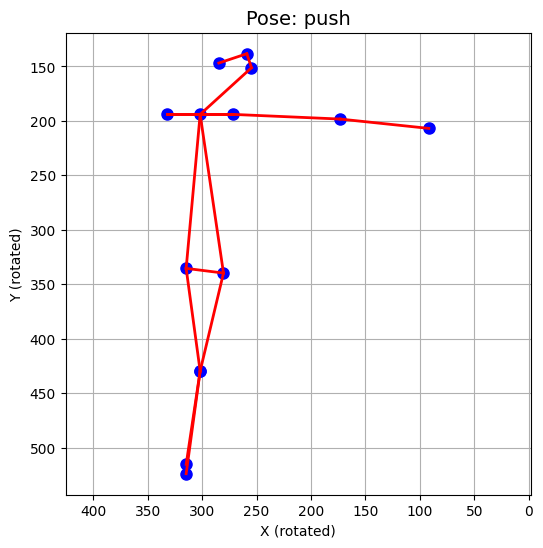

In [ ]:
# Visualize a sample
sample_idx = 97
plot_pose(skel[sample_idx], labels[sample_idx])

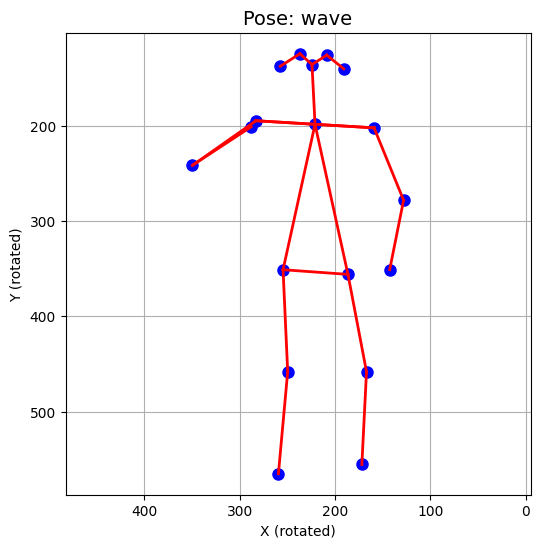

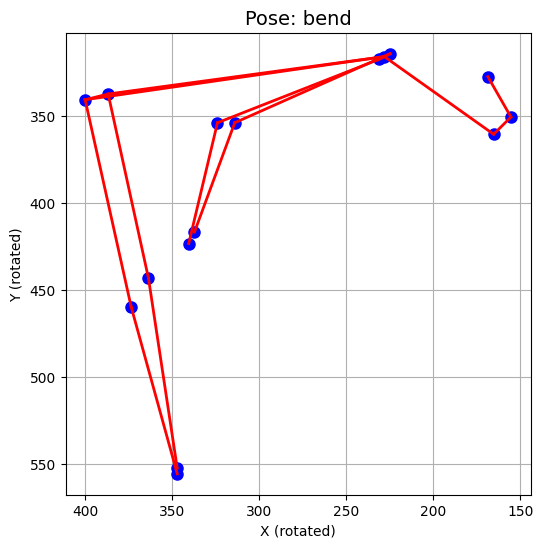

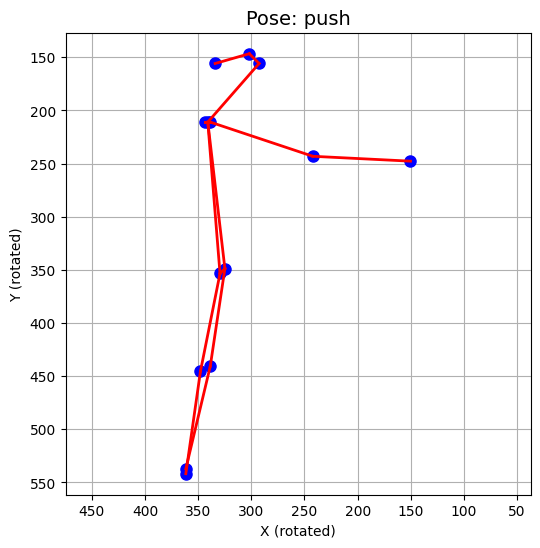

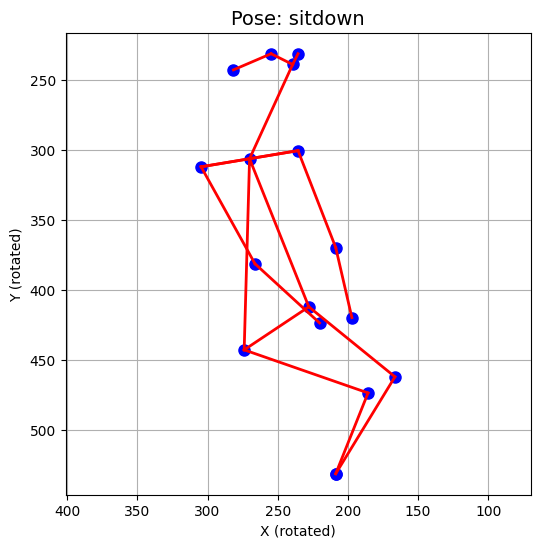

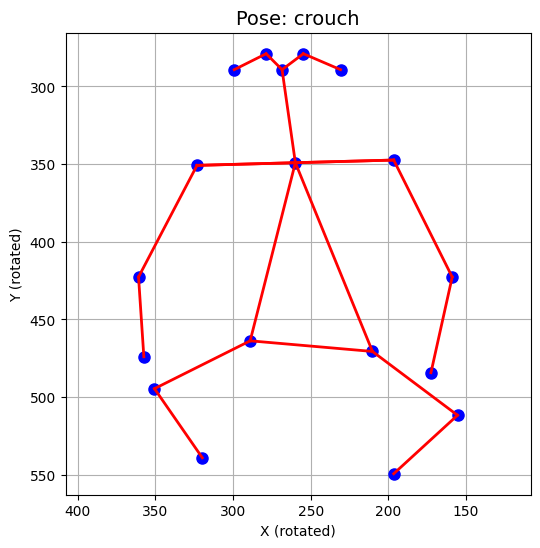

In [ ]:
# Plot a few random examples from training data
for idx in [0, 5, 13, 43, 41]:
    plot_pose(skel[idx], labels[idx])


In [ ]:


# Load the train features CSV file (change the path if necessary)

trainfeatures_path = '/content/drive/Shareddrives/ML4Net/ML4NetSeminari2/Train_features.csv'

train_features = pd.read_csv(trainfeatures_path, header=None).values

# Check the shape of the data to understand its structure (should be 1000 rows x 270 columns)
print(train_features.shape)


(1000, 270)


In [ ]:
# Compute the average CSI per subcarrier (averaging each column)
average_csi_per_subcarrier = train_features.mean(axis=0)

# Check the first few values to confirm
print(average_csi_per_subcarrier[:5])


[ 9.43202748 13.30960525 15.25093571 17.01113385 18.35954212]


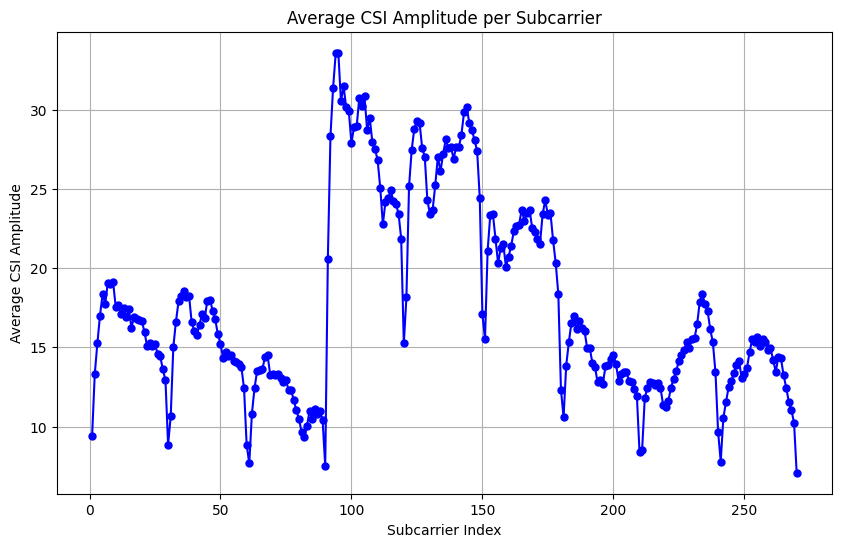

In [ ]:


# Step 2: Compute the average CSI amplitude per subcarrier
average_csi_per_subcarrier = train_features.mean(axis=0)

# Step 3: Plot the average CSI amplitudes per subcarrier as a line plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, 271), average_csi_per_subcarrier, marker='o', color='b', linestyle='-', markersize=5)

# Adding labels and title
plt.title('Average CSI Amplitude per Subcarrier')
plt.xlabel('Subcarrier Index')
plt.ylabel('Average CSI Amplitude')

# Display grid for easier visualization
plt.grid(True)

# Show the plot
plt.show()


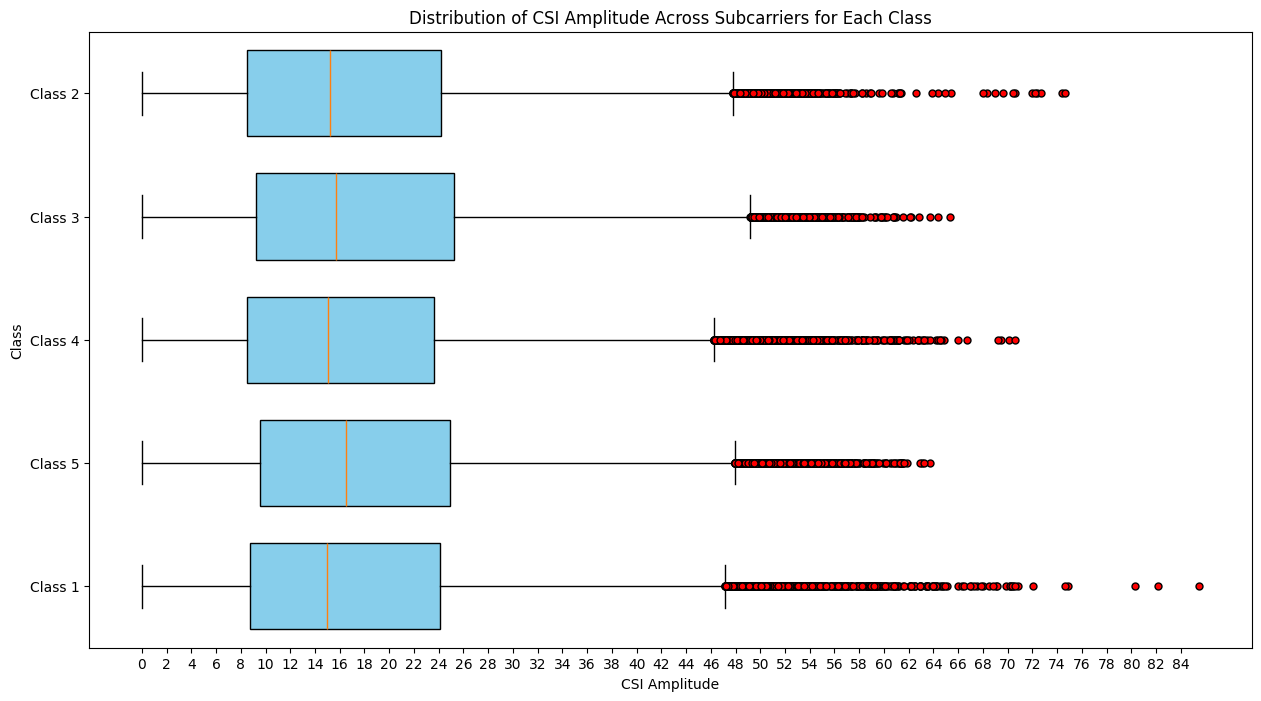

In [ ]:
# Finally, plot the distribution of the CSI amplitude across each subcarrier for each class.


# Step 1: Load the train features and train labels
trainfeatures_path = '/content/drive/Shareddrives/ML4Net/ML4NetSeminari2/Train_features.csv'
trainlabels_path = '/content/drive/Shareddrives/ML4Net/ML4NetSeminari2/Train_labels.csv'

train_features = pd.read_csv(trainfeatures_path, header=None)
train_labels = pd.read_csv(trainlabels_path, header=None).squeeze()

# Step 2: Prepare data for plotting
# Combine the features and labels into a single DataFrame for easier manipulation
train_features['label'] = train_labels

# Step 3: Create a list to hold the CSI data for each class
# We'll organize the CSI data by class for each subcarrier
classes = train_features['label'].unique()
csi_data_by_class = {cls: [] for cls in classes}

# Group CSI data by class
for cls in classes:
    csi_data_by_class[cls] = train_features[train_features['label'] == cls].drop(columns=['label']).values

# Step 4: Plot the distribution of CSI amplitude across each subcarrier for each class
plt.figure(figsize=(15, 8))

# Prepare the data in the correct format for boxplot
# Flatten the data into a list of values for each class (each class as a list of amplitudes)
boxplot_data = [csi_data_by_class[cls].flatten() for cls in classes]

# Plot a boxplot for each class
plt.boxplot(boxplot_data,
            vert=False,  # Horizontal boxplot
            patch_artist=True,  # Fill the box with color
            boxprops=dict(facecolor="skyblue", color="black"),
            flierprops=dict(markerfacecolor='r', marker='o', markersize=5),
            widths=0.7)

# Adding titles and labels
plt.title('Distribution of CSI Amplitude Across Subcarriers for Each Class')
plt.xlabel('CSI Amplitude')
plt.ylabel('Class')

# Modify the x-axis tick labels (use tick_labels instead of labels)
plt.xticks(np.arange(min(train_features.values.flatten()), max(train_features.values.flatten()), step=2))

# Adding class labels to the y-axis
plt.yticks(np.arange(1, len(classes) + 1), [f'Class {cls}' for cls in classes])

# Display the plot
plt.show()


In [ ]:
# Imports
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


In [ ]:
# Load training and test data from Google Drive
trainfeatures_path = '/content/drive/Shareddrives/ML4Net/ML4NetSeminari2/Train_features.csv'
trainlabels_path = '/content/drive/Shareddrives/ML4Net/ML4NetSeminari2/Train_labels.csv'
testfeatures_path = '/content/drive/Shareddrives/ML4Net/ML4NetSeminari2/Test_features.csv'
testlabels_path = '/content/drive/Shareddrives/ML4Net/ML4NetSeminari2/Test_labels.csv'


X_train = pd.read_csv(trainfeatures_path).values
y_train = pd.read_csv(trainlabels_path, header=None).squeeze().values
X_test = pd.read_csv(testfeatures_path).values
y_test = pd.read_csv(testlabels_path, header=None).squeeze().values

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = y_train[:X_train_scaled.shape[0]]
y_test = y_test[:X_test_scaled.shape[0]]

# Train SVM
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

## Part II – SVM Model Evaluation

After training the SVM model with the normalized training data, we proceed to evaluate its performance on the test set. We use the accuracy metric and a confusion matrix to assess how well the classifier performs on each class.

In [ ]:
# Evaluate
y_pred = svm.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2%}")

Test Accuracy: 25.63%


### Model Accuracy

The model achieved an accuracy of approximately **25.63%** on the test set. This result is relatively low (a random classifier for 5 classes would reach ~20%), which suggests that:
- The features may not be easily separable using the current SVM parameters.
- Additional preprocessing, better feature engineering, or parameter tuning might be needed.


Test Accuracy: 25.63%


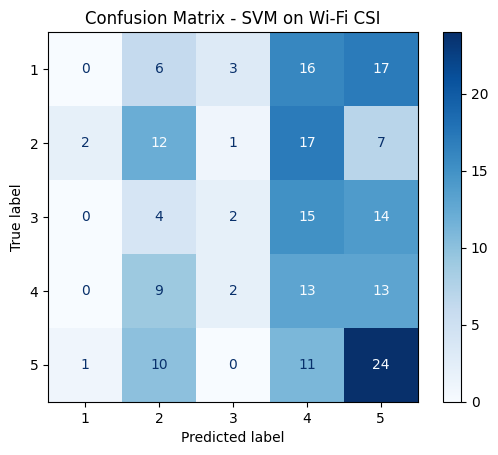

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - SVM on Wi-Fi CSI")
plt.show()


### Confusion Matrix

The confusion matrix shows how the predicted labels compare to the true labels, allowing us to identify patterns in misclassification.

In the matrix:
- Class **1 (wave)** is often confused with **4 (sitdown)** and **5 (bend)**.
- Class **5 (bend)** has the highest number of correct predictions.

Using human-readable labels (`wave`, `push`, `crouch`, `sitdown`, `bend`) helps to interpret the results more clearly.


## Conclusion

In this seminar, we implemented and evaluated a Support Vector Machine (SVM) classifier using Wi-Fi Channel State Information (CSI) data for human pose recognition. While the performance was modest, the notebook demonstrates the full machine learning pipeline: from data preparation and feature analysis to model training and evaluation.
